In [2]:
from aart_func import *
from params import * # The file params.py contains all the relevant parameters for the simulations
from astropy import units as u
import kgeo
import tools as tls
import subprocess
import scipy.interpolate
from matplotlib import ticker
%load_ext autoreload
%autoreload 2
import importlib 
from matplotlib.lines import Line2D
import matplotlib.image as mpimg


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Welcome to eht-imaging! v 1.2.5 


## Lensing bands calculation

In [ ]:
%time !python3 lensingbands.py

In [3]:
fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])

h5f.close()

Reading file:  ./Results/LensingBands_a_0.94_i_17.h5


# Analytical Ray-tracing

In [ ]:
%time !python3 raytracing.py

In [4]:
fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]

h5f.close()

Reading file:  ./Results/Rays_a_0.94_i_17.h5


# Computing images

In [5]:

args = ' '
cmd_args = [
   	'--nu ',
	'--mass ',
	'--scaleh ',
	'--thetab ',
	'--beta ',
    '--Rie ',
    '--Bchoi ',
	'--rb0 ',
	'--nth0 ',
	'--te0 ',
	'--pdens ',
	'--ptemp ' 
]
brightparams = [
	230e9, # nu0
	(MMkg * u.kg).to(u.g).value, # mass
	.5, # scale_height
	50.0 * (np.pi / 180), # theta_b
	1.0, # beta
	10.0, # Rie
	0, # Bchoice
	2, # rb
	1.0726e+05, # n_th0
	1.2428e+11, # t_e0
	-.7, # p_dens
	-.84 # p_temp
]
# brightparams = [
# 	230e9, # nu0
# 	(MMkg * u.kg).to(u.g).value, # mass
# 	.5, # scale_height
# 	50.0 * (np.pi / 180), # theta_b
# 	1.0, # beta
# 	10.0, # Rie
# 	0, # Bchoice
# 	2, # rb
# 	2.1526e+04, # n_th0
# 	1.2428e+11, # t_e0
# 	-.7, # p_dens
# 	-.3 # p_temp
# ]



for i in range(len(brightparams)):
    args = args + cmd_args[i] + str(brightparams[i]) + ' '
aartpath = '/home/tej/Desktop/Code_Stuff/Repositories/aart'

In [ ]:
subprocess.run(['python3 ' + aartpath + '/radialintensity.py' + args], shell=True)

In [6]:
fnrays='./Results/Intensity_a_{}_i_{}_nu_{}_mass_{}_scaleh_{}_thetab_{}_beta_{}_Rie_{}_Bchoi_{}_rb_{}_nth0_{}_te0_{}_pdens_{}_ptemp_{}.h5'.format(
    spin_case,
    i_case,
    "{:.1e}".format(brightparams[0]),
    "{:.1e}".format(brightparams[1]), 
    float(brightparams[2]),
    "{:.3e}".format(brightparams[3]), 
    float(brightparams[4]),
    float(brightparams[5]), 
    float(brightparams[6]),
    float(brightparams[7]),
    "{:.1e}".format(brightparams[8]),
    "{:.1e}".format(brightparams[9]),
    float(brightparams[10]),
    float(brightparams[11]))
print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

I0=h5f['bghts0'][:]
I1=h5f['bghts1'][:]
I2=h5f['bghts2'][:]

h5f.close()


Reading file:  ./Results/Intensity_a_0.94_i_17_nu_2.3e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0_Rie_10.0_Bchoi_0.0_rb_2.0_nth0_1.1e+05_te0_1.2e+11_pdens_-0.7_ptemp_-0.84.h5


0.9765280822852411 Jy


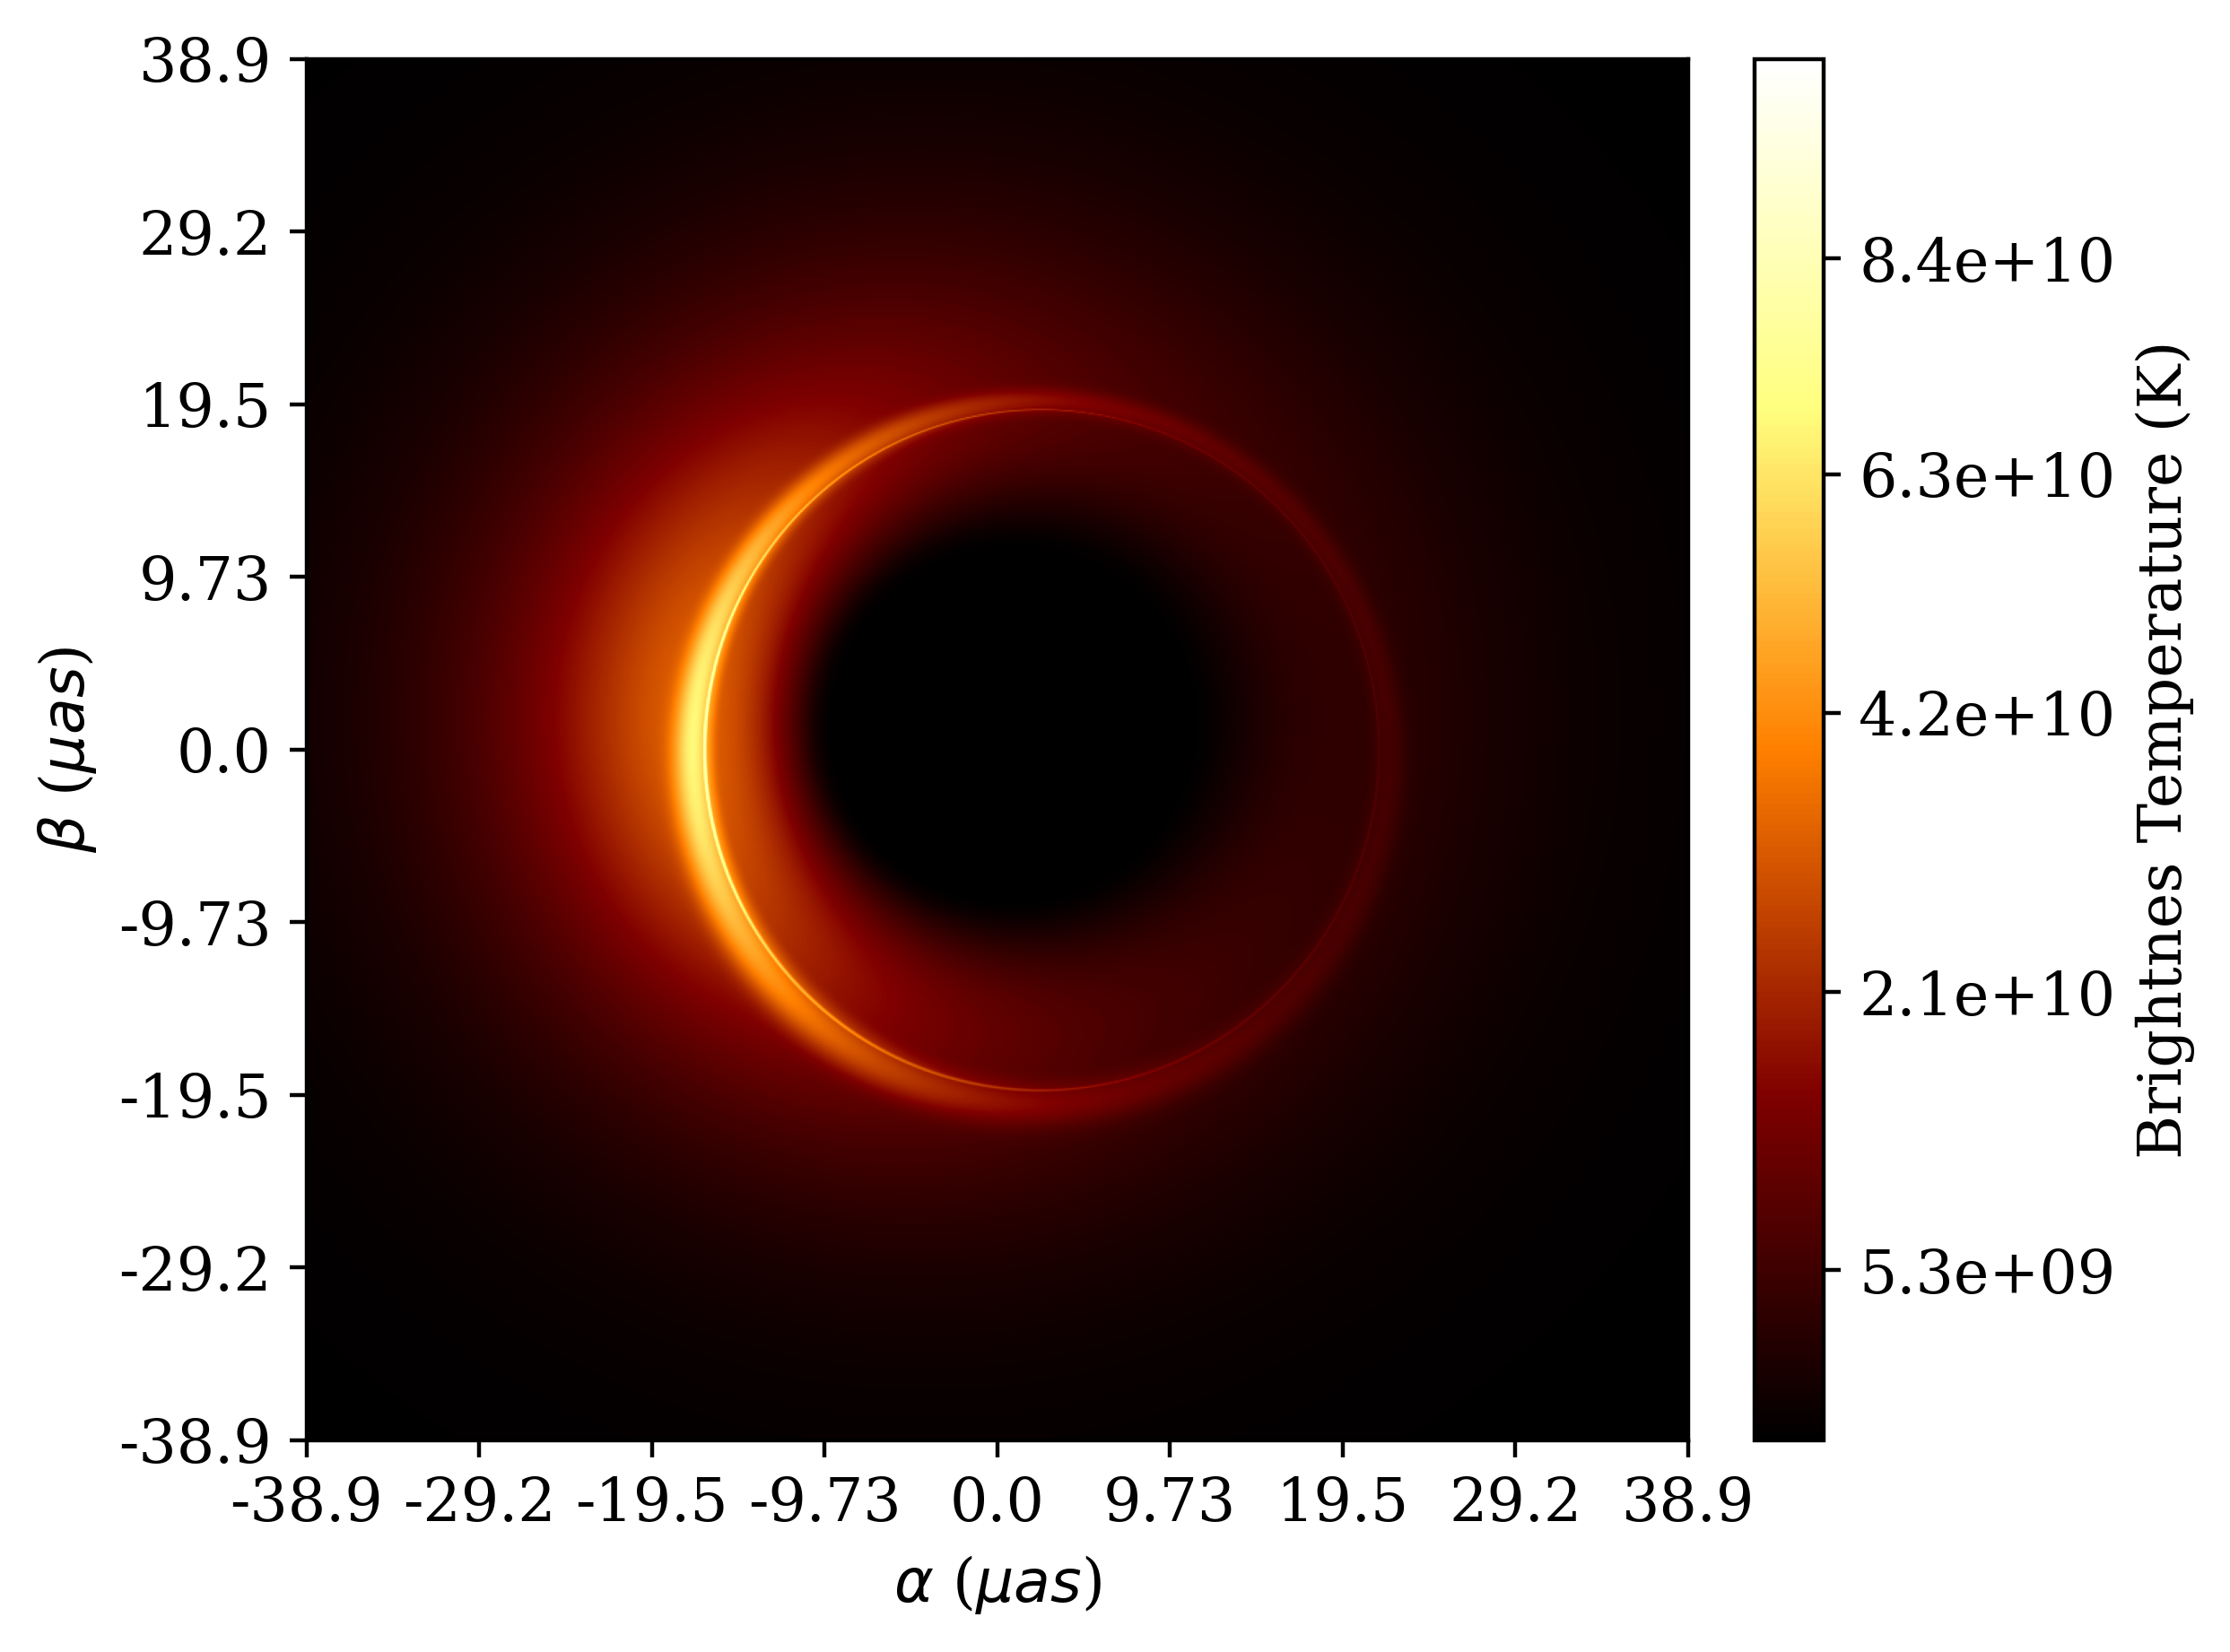

In [6]:
one_M = ilp.rg_func(brightparams[1] * u.g).to(u.m)
M2rads = np.arctan(one_M.value / dBH)
M2uas = np.arctan(one_M.value / dBH)/muas_to_rad
# Mass distance units of 1 = .5842 uas

vmax = np.max(I0+I1+I2)*1.2
vmin = np.max(I0+I1+I2)* .1
fig, ax = plt.subplots(figsize=[6,5],dpi=400)
#im = ax.imshow(I0+I1+I2,vmax=np.max(I0+I1+I2)*1.2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
im = ax.imshow(I0 + I1 + I2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],
               norm=matplotlib.colors.PowerNorm(.7,vmax=vmax))

#im = ax.imshow(blurred,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])


ax.set_xlim(-10,10) # units of M
ax.set_ylim(-10,10) 
    
ax.set_xlabel(r"$\alpha$"+" "+r"($\mu as$)")
ax.set_ylabel(r"$\beta$"+" "+r"($\mu as$)")

ax.set_xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10], labels=[
    str('{:.3}'.format(-10 * M2uas)),
    str('{:.3}'.format(-7.5 * M2uas)),
    str('{:.3}'.format(-5 * M2uas)),
    str('{:.3}'.format(-2.5 * M2uas)),
    str('{:.3}'.format(0 * M2uas)),
    str('{:.3}'.format(2.5 * M2uas)),
    str('{:.3}'.format(5 * M2uas)), 
    str('{:.3}'.format(7.5 * M2uas)), 
    str('{:.3}'.format(10 * M2uas))
    ])

ax.set_yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10], labels=[
    str('{:.3}'.format(-10 * M2uas)),
    str('{:.3}'.format(-7.5 * M2uas)),
    str('{:.3}'.format(-5 * M2uas)),
    str('{:.3}'.format(-2.5 * M2uas)),
    str('{:.3}'.format(0 * M2uas)),
    str('{:.3}'.format(2.5 * M2uas)),
    str('{:.3}'.format(5 * M2uas)), 
    str('{:.3}'.format(7.5 * M2uas)), 
    str('{:.3}'.format(10 * M2uas))
    ])

colorbar=plt.colorbar(im, fraction=0.046, pad=0.04, format='%.1e', ticks=[
    vmax*.8,
    vmax*.6,
    vmax*.4,
    vmax*.2,
    vmax*.05
    ],
    label="Brightnes Temperature (K)"
    )
print(ilp.total_jy(I0 + I1 + I2, brightparams[0], brightparams[1]))

radius = tls.radii_of_theta(I0,100)
theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1) / 100)
radius1 = tls.radii_of_theta(I1,100)
radius2 = tls.radii_of_theta(I2,100)

alpha =  radius * np.cos(theta)
beta =  radius * np.sin(theta)
alpha1 =  radius1 * np.cos(theta)
beta1 =  radius1 * np.sin(theta)
alpha2 =  radius2 * np.cos(theta)
beta2 =  radius2 * np.sin(theta)

# plt.plot(alpha, beta, 'b')
# plt.plot(alpha2, beta2, 'r')
# plt.plot(alphas_inner, betas_inner, '--c')
# plt.plot(alphas_outer, betas_outer, '--m')

# theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1)/100)
# radii = np.array(tls.radii_of_theta(I0,100)) /100
# beta =  radii * np.sin(theta)
# alpha =  radii * np.cos(theta)
# plt.plot(alpha, beta, 'r')
# plt.savefig('BHImage_a_{}_i_{}_nu_{}_mass_{}_scaleh_{}_thetab_{}_beta_{}_Rie_{}_Bchoi_{}_rb_{}_nth0_{}_te0_{}_pdens_{}_ptemp_{}.png'.format(
#     spin_case,
#     i_case,
#     "{:.1e}".format(brightparams[0]),
#     "{:.1e}".format(brightparams[1]), 
#     brightparams[2],
#     "{:.3e}".format(brightparams[3]), 
#     brightparams[4],
#     brightparams[5], 
#     brightparams[6],
#     brightparams[7],
#     "{:.1e}".format(brightparams[8]),
#     "{:.1e}".format(brightparams[9]),
#     brightparams[10],
#     brightparams[11]),
#     bbox_inches='tight'
# )
plt.show()

# Figures

/tmp/ipykernel_17407/4278865643.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(2,1,2)


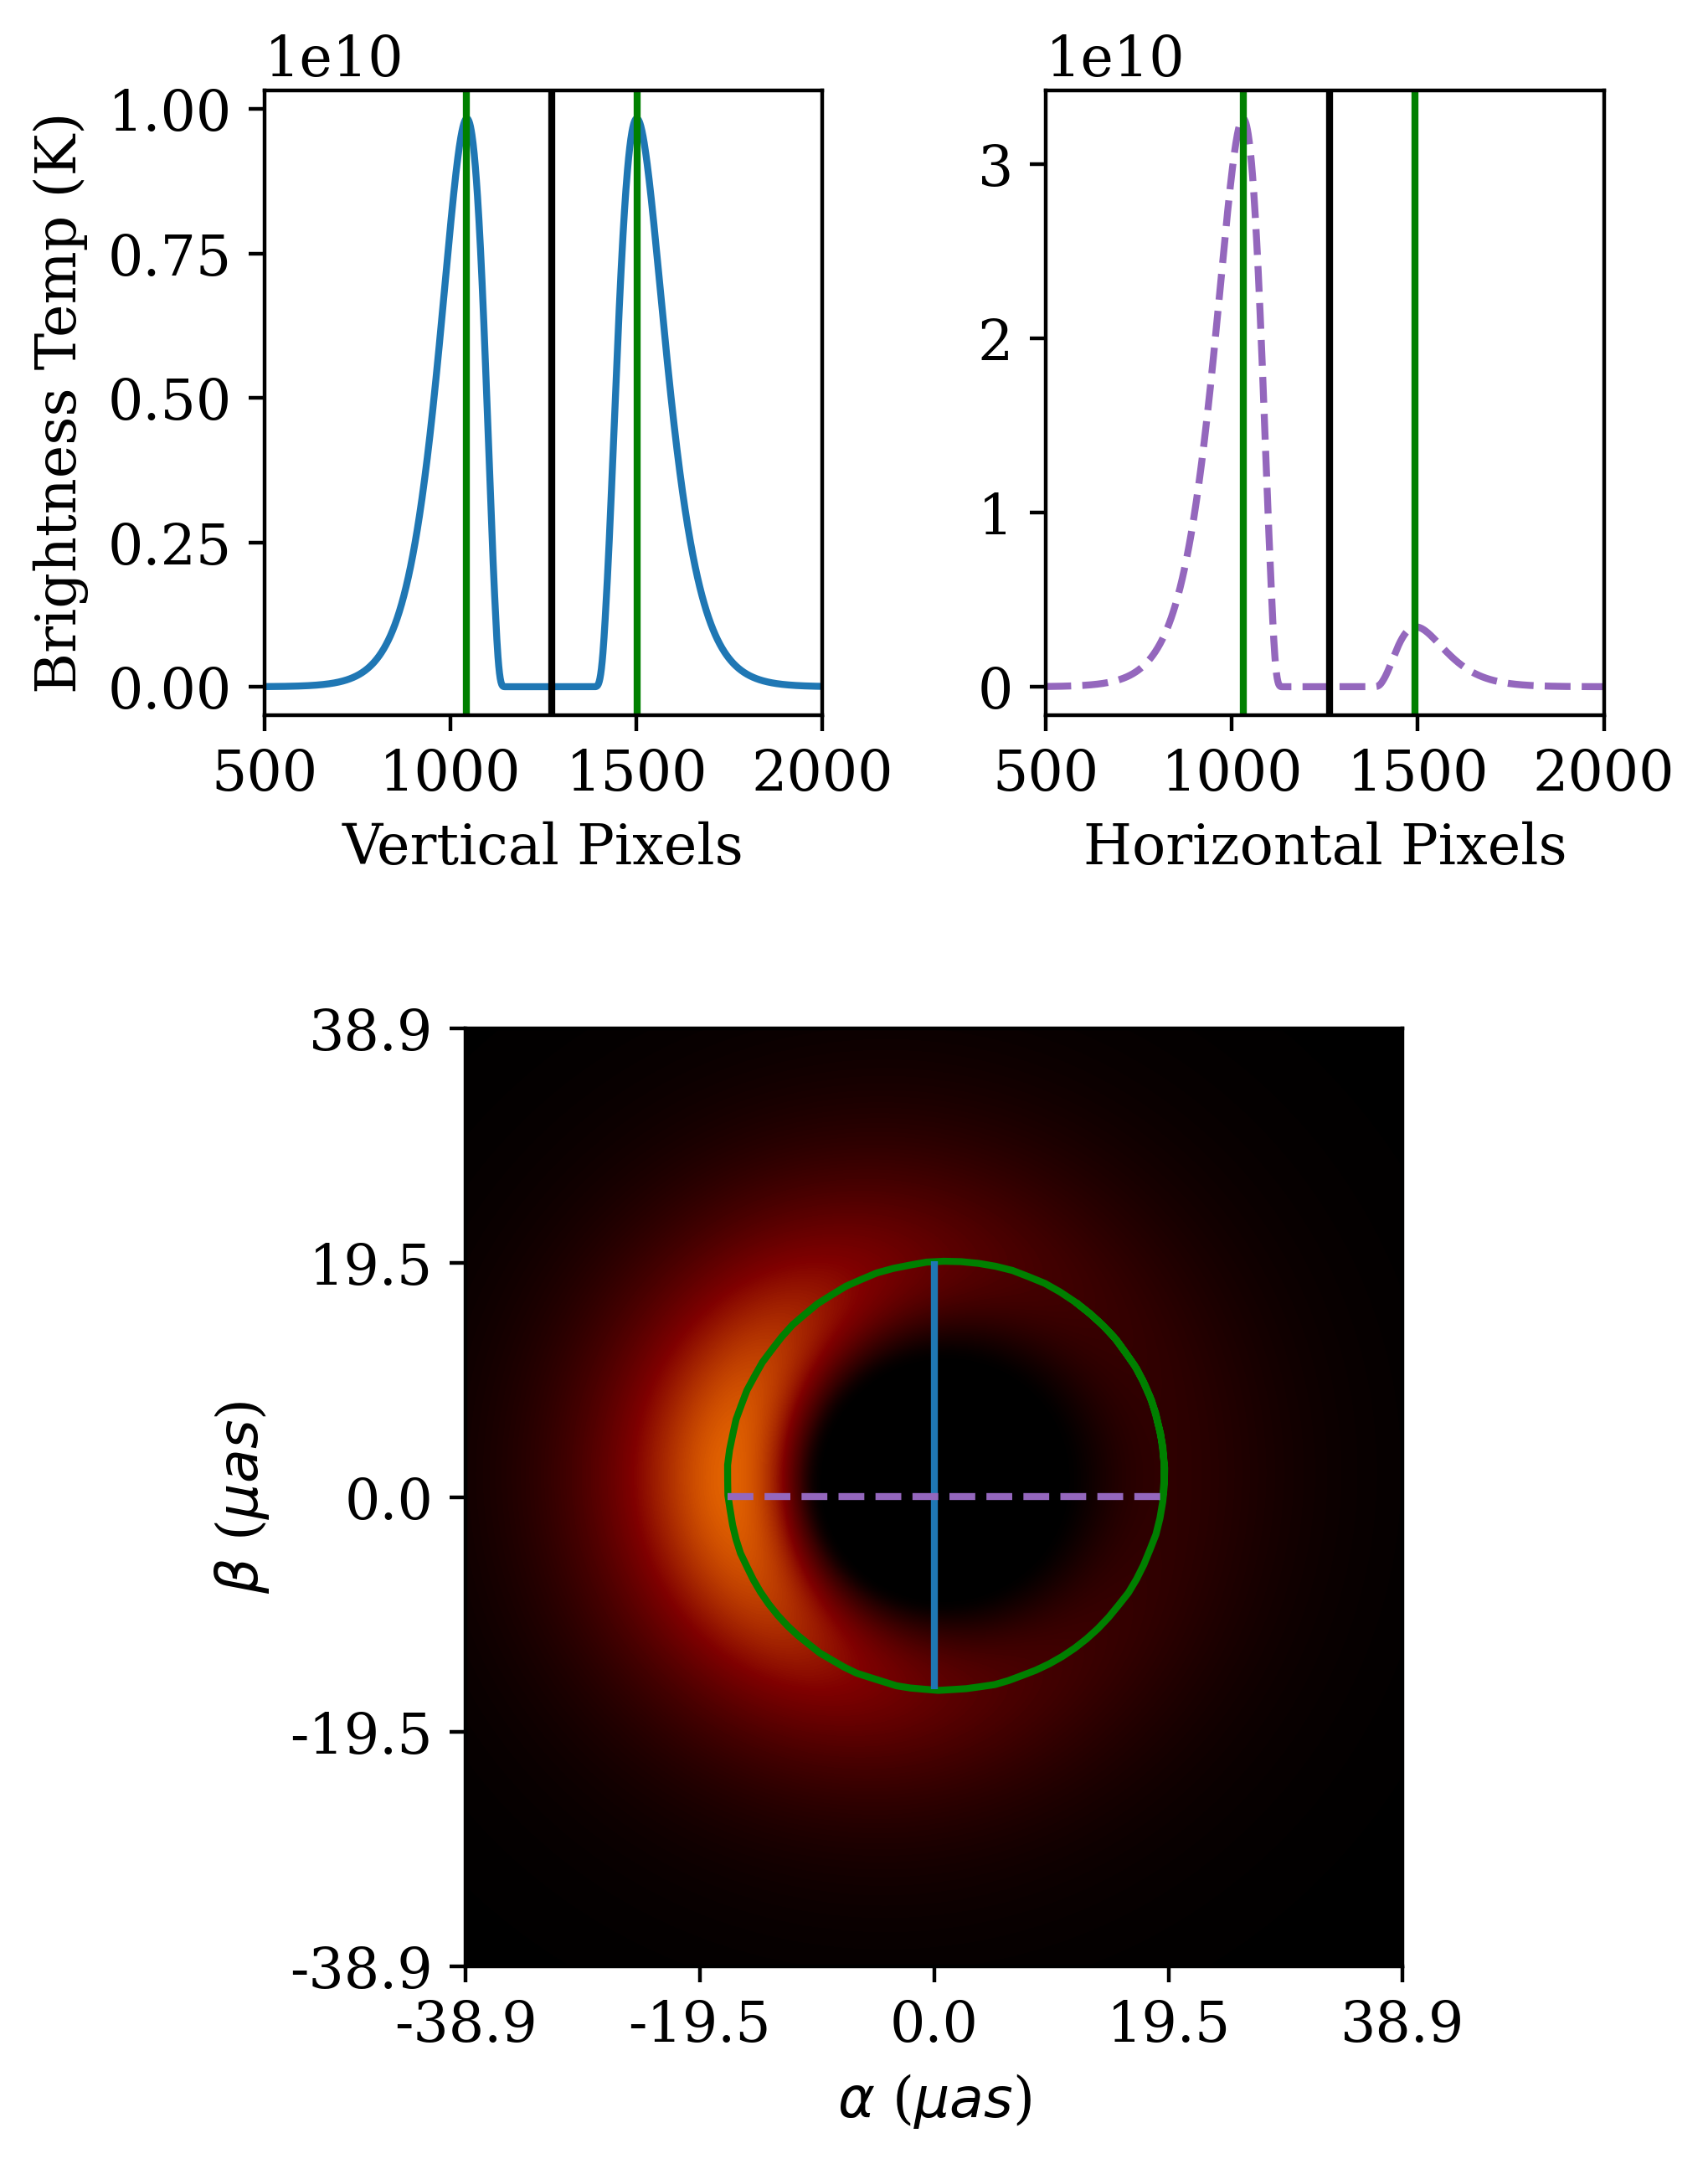

In [20]:
def thetaconvert(thetanumber): 
    return int((thetanumber / (2*np.pi + 1)) * 100)

'''FIGURE 2--------------------------------------------------------------------------------------------------'''
midpoint = int(I0.shape[0]/2)
diam  = ilp.ring_radius(I0) * (I0.shape[0] / (limits*2)) # in pixels
xval, yval = tls.center_finder(I0)
fig = plt.subplots(2, 2, figsize=[10,14], height_ratios=[1,2],dpi=400)


radius = tls.radii_of_theta(I0,100)
theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1) / 100)

print()

alpha =  radius * np.cos(theta)
beta =  radius * np.sin(theta)

ax = [None, None, None]
ax[0] = plt.subplot(2,2,1)
ax[1] = plt.subplot(2,2,2)
ax[2] = plt.subplot(2,1,2)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.5,
                    top=.5,
                    wspace=0.4,
                    hspace=0.001)


ax[0].plot(I0[:,midpoint])
ax[0].axvline(yval - diam, color='g')
ax[0].axvline(yval + diam, color='g')
ax[0].axvline(yval, color='0')
ax[0].set_xlim(500,2000)
ax[0].set_ylabel("Brightness Temp (K)", fontsize=12)
ax[0].set_xlabel("Vertical Pixels", fontsize=12)


ax[1].plot(I0[midpoint,:], color='tab:purple', linestyle='--')
ax[1].axvline(xval - diam, color='g')
ax[1].axvline(xval + diam, color='g')
ax[1].axvline(xval, color='0')
ax[1].set_xlim(500,2000)
ax[1].set_xlabel("Horizontal Pixels", fontsize=12)


one_M = ilp.rg_func(brightparams[1] * u.g).to(u.m)
M2rads = np.arctan(one_M.value / dBH)
M2uas = np.arctan(one_M.value / dBH)/muas_to_rad
# Mass distance units of 1 = .5842 uas

xval, yval = tls.center_finder(I0)


vmax = np.max(I0+I1+I2)*1.2
vmin = np.max(I0+I1+I2)* .1
im = ax[2].imshow(I0,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],
               norm=matplotlib.colors.PowerNorm(.7,vmax=vmax))

# #im = ax.imshow(blurred,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])


ax[2].set_xlim(-10,10) # units of M
ax[2].set_ylim(-10,10) 
    
ax[2].set_xlabel(r"$\alpha$"+" "+r"($\mu as$)")
ax[2].set_ylabel(r"$\beta$"+" "+r"($\mu as$)")

ax[2].set_xticks([-10, -5, 0, 5, 10], labels=[
    str('{:.3}'.format(-10 * M2uas)),
    str('{:.3}'.format(-5 * M2uas)),
    str('{:.3}'.format(0 * M2uas)),
    str('{:.3}'.format(5 * M2uas)), 
    str('{:.3}'.format(10 * M2uas))
    ])


ax[2].set_yticks([-10, -5, 0, 5, 10], labels=[
    str('{:.3}'.format(-10 * M2uas)),
    str('{:.3}'.format(-5 * M2uas)),
    str('{:.3}'.format(0 * M2uas)),
    str('{:.3}'.format(5 * M2uas)), 
    str('{:.3}'.format(10 * M2uas))
    ])

ax[2].plot(alpha, beta, 'g')


ax[2].vlines((xval - (I0.shape[0] / 2)) / I0.shape[0], -radius[thetaconvert( 3 * np.pi / 2)], radius[thetaconvert(np.pi / 2)], color='tab:blue')
ax[2].hlines((yval - (I0.shape[0] / 2)) / I0.shape[0] , -radius[thetaconvert( np.pi)], radius[0], color='tab:purple', linestyle='--')

plt.savefig('./Paper_Figures/Figure_Radii.png', bbox_inches='tight')


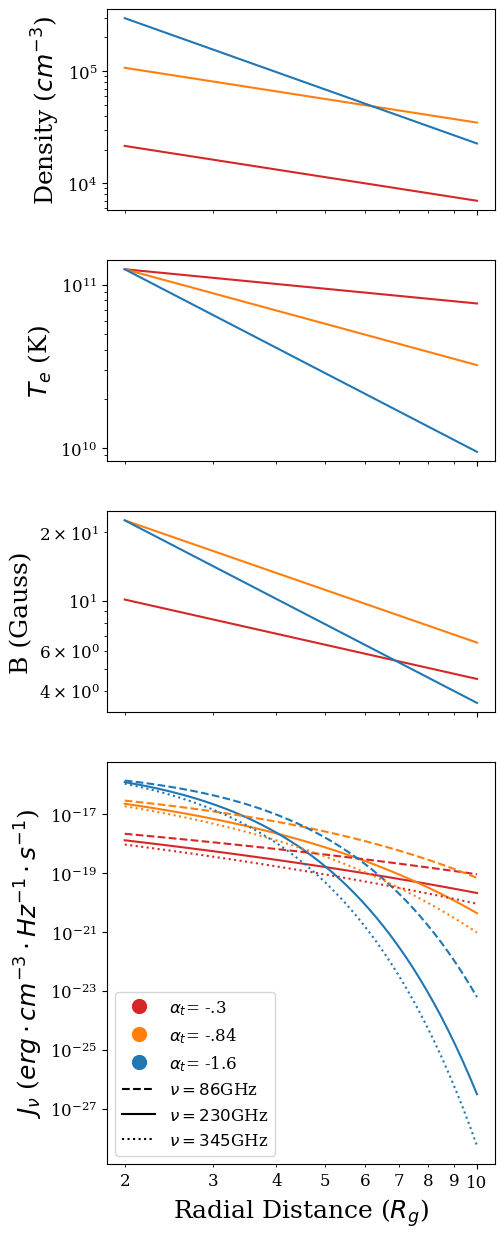

In [13]:
r_array = np.logspace(np.log10(2), np.log10(10)) * u.dimensionless_unscaled
r_array[0].unit
def j_coeff_func(r, redshift, nu0=ilp.kw_nu0,mass=ilp.kw_mass, theta_b=ilp.kw_theta_b, 
            beta=ilp.kw_beta,rb_0=ilp.kw_rb_0,n_th0=ilp.kw_n_th0,t_e0=ilp.kw_t_e0,p_dens=ilp.kw_p_dens,p_temp=ilp.kw_p_temp):
    n = ilp.nth_func(r,mass,rb_0,n_th0,p_dens)
    theta_e = ilp.theta_e_func(r,mass,rb_0,t_e0,p_temp)
    nu_c = ilp.nu_c_func(r,mass,theta_b,rb_0,t_e0,p_temp)
    nu = nu0/redshift
    x = nu / (nu_c)
    # Returns units of [u.erg / (u.cm ** 3 * u.s * u.Hz)]
    return n * ilp.e ** 2 * nu * ilp.synchrotron_func(x) / (2 * np.sqrt(3) * ilp.c * theta_e ** 2)

'''FIGURE 4--------------------------------------------------------------------------------------------------'''

fig = plt.subplots(4,1, sharex='col', figsize=(5,15), height_ratios=[1,1,1,2])

ax = [None, None, None, None]

# Feducial ORange
# 	1.23e4, # n_th0
# 	8.1e9, # t_e0
# 	-.7, # p_dens
# 	-.84 # p_temp

# Steeper Blue
# 	2.9726e+05, # n_th0
# 	-.7, # p_dens
# 	-1.6 # p_temp

# Shallower RED
# 	2.1526e+04, # n_th0
# 	-.7, # p_dens
# 	-.3 # p_temp


# Subplot 1-----------------------------------------
ax[0] = plt.subplot(4,1,1)
ax[0].plot(r_array, ilp.nth_func(r_array, n_th0=2.1526e+04 * ilp.cmcubed), 'tab:red')
ax[0].plot(r_array, ilp.nth_func(r_array), 'tab:orange')
ax[0].plot(r_array, ilp.nth_func(r_array, p_dens=-1.6, n_th0=2.9726e+05 * ilp.cmcubed), 'tab:blue')

ax[0].set_ylabel('Density ({})'.format(R'$cm^{-3}$'), fontsize=18)
ax[0].set_yscale('log')


# Subplot 1-----------------------------------------
ax[1] = plt.subplot(4,1,2)

ax[1].plot(r_array, ilp.te_func(r_array, p_temp=-.3), 'tab:red')
ax[1].plot(r_array, ilp.te_func(r_array), 'tab:orange')
ax[1].plot(r_array, ilp.te_func(r_array, p_temp=-1.6), 'tab:blue')

ax[1].set_ylabel(R'$T_e$ (K)', fontsize=18)
ax[1].set_yscale('log')


# Subplot 1-----------------------------------------
ax[2] = plt.subplot(4,1,3)

ax[2].plot(r_array, ilp.b_func_true(r_array, p_temp=-.3, n_th0=2.1526e+04 * ilp.cmcubed), 'tab:red')
ax[2].plot(r_array, ilp.b_func_true(r_array), 'tab:orange')
ax[2].plot(r_array, ilp.b_func_true(r_array, p_temp=-1.6), 'tab:blue')


ax[2].set_yscale('log')
ax[2].set_ylabel('B (Gauss)', fontsize=18)

# Subplot 1-----------------------------------------
ax[3] = plt.subplot(4,1,4)


ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-.3, n_th0=2.1526e+04 * ilp.cmcubed), 'tab:red', label=R"$\alpha_t$= -.3")
ax[3].plot(r_array, ilp.emission_coeff(r_array,1), 'tab:orange',label=R"$\alpha_t$= -.84")
ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-1.6, n_th0=2.9726e+05 * ilp.cmcubed), 'tab:blue', label=R"$\alpha_t$= -1.6")


ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-.3, nu0 =86e9 * ilp.Hz, n_th0=2.1526e+04 * ilp.cmcubed), 'tab:red', linestyle='--')
ax[3].plot(r_array, ilp.emission_coeff(r_array,1, nu0 =86e9 * ilp.Hz), 'tab:orange', linestyle='--')
ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-1.6, nu0 =86e9 * ilp.Hz, n_th0=2.9726e+05 * ilp.cmcubed), 'tab:blue', linestyle='--')


ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-.3, nu0=345e9 * ilp.Hz, n_th0=2.1526e+04 * ilp.cmcubed), 'tab:red', linestyle=':')
ax[3].plot(r_array, ilp.emission_coeff(r_array,1, nu0=345e9 * ilp.Hz), 'tab:orange', linestyle=':')
ax[3].plot(r_array, ilp.emission_coeff(r_array,1, p_temp=-1.6, nu0=345e9 * ilp.Hz, n_th0=2.9726e+05 * ilp.cmcubed), 'tab:blue', linestyle=':')

ax[3].set_ylabel(R'$J_\nu$ ($erg \cdot cm^{-3} \cdot Hz^{-1} \cdot s^{-1}$)', fontsize=18)
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[3].minorticks_on()
ax[3].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax[3].xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.0f'))
ax[3].set_xlabel('Radial Distance ({})'.format(R'$R_g$'), fontsize=18 )

lines = [
    Line2D([0],[0],marker='o', markerfacecolor='tab:red', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:orange', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:blue', color='w', markersize=12),
    Line2D([0,1],[0,1],linestyle='--', color='k'), 
    Line2D([0,1],[0,1],linestyle='-', color='k'), 
    Line2D([0,1],[0,1],linestyle=':', color='k')
    ]
labels = [
    R"$\alpha_t$= -.3",
    R"$\alpha_t$= -.84",
    R"$\alpha_t$= -1.6",
    R'$\nu = 86$GHz',
    R'$\nu = 230$GHz',
    R'$\nu = 345$GHz'
          ]

ax[3].legend(lines,labels)




plt.savefig('./Paper_Figures/Figure_powerlaws.png', bbox_inches='tight')

/tmp/ipykernel_6596/2578269837.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0] = plt.subplot(2,1,1)


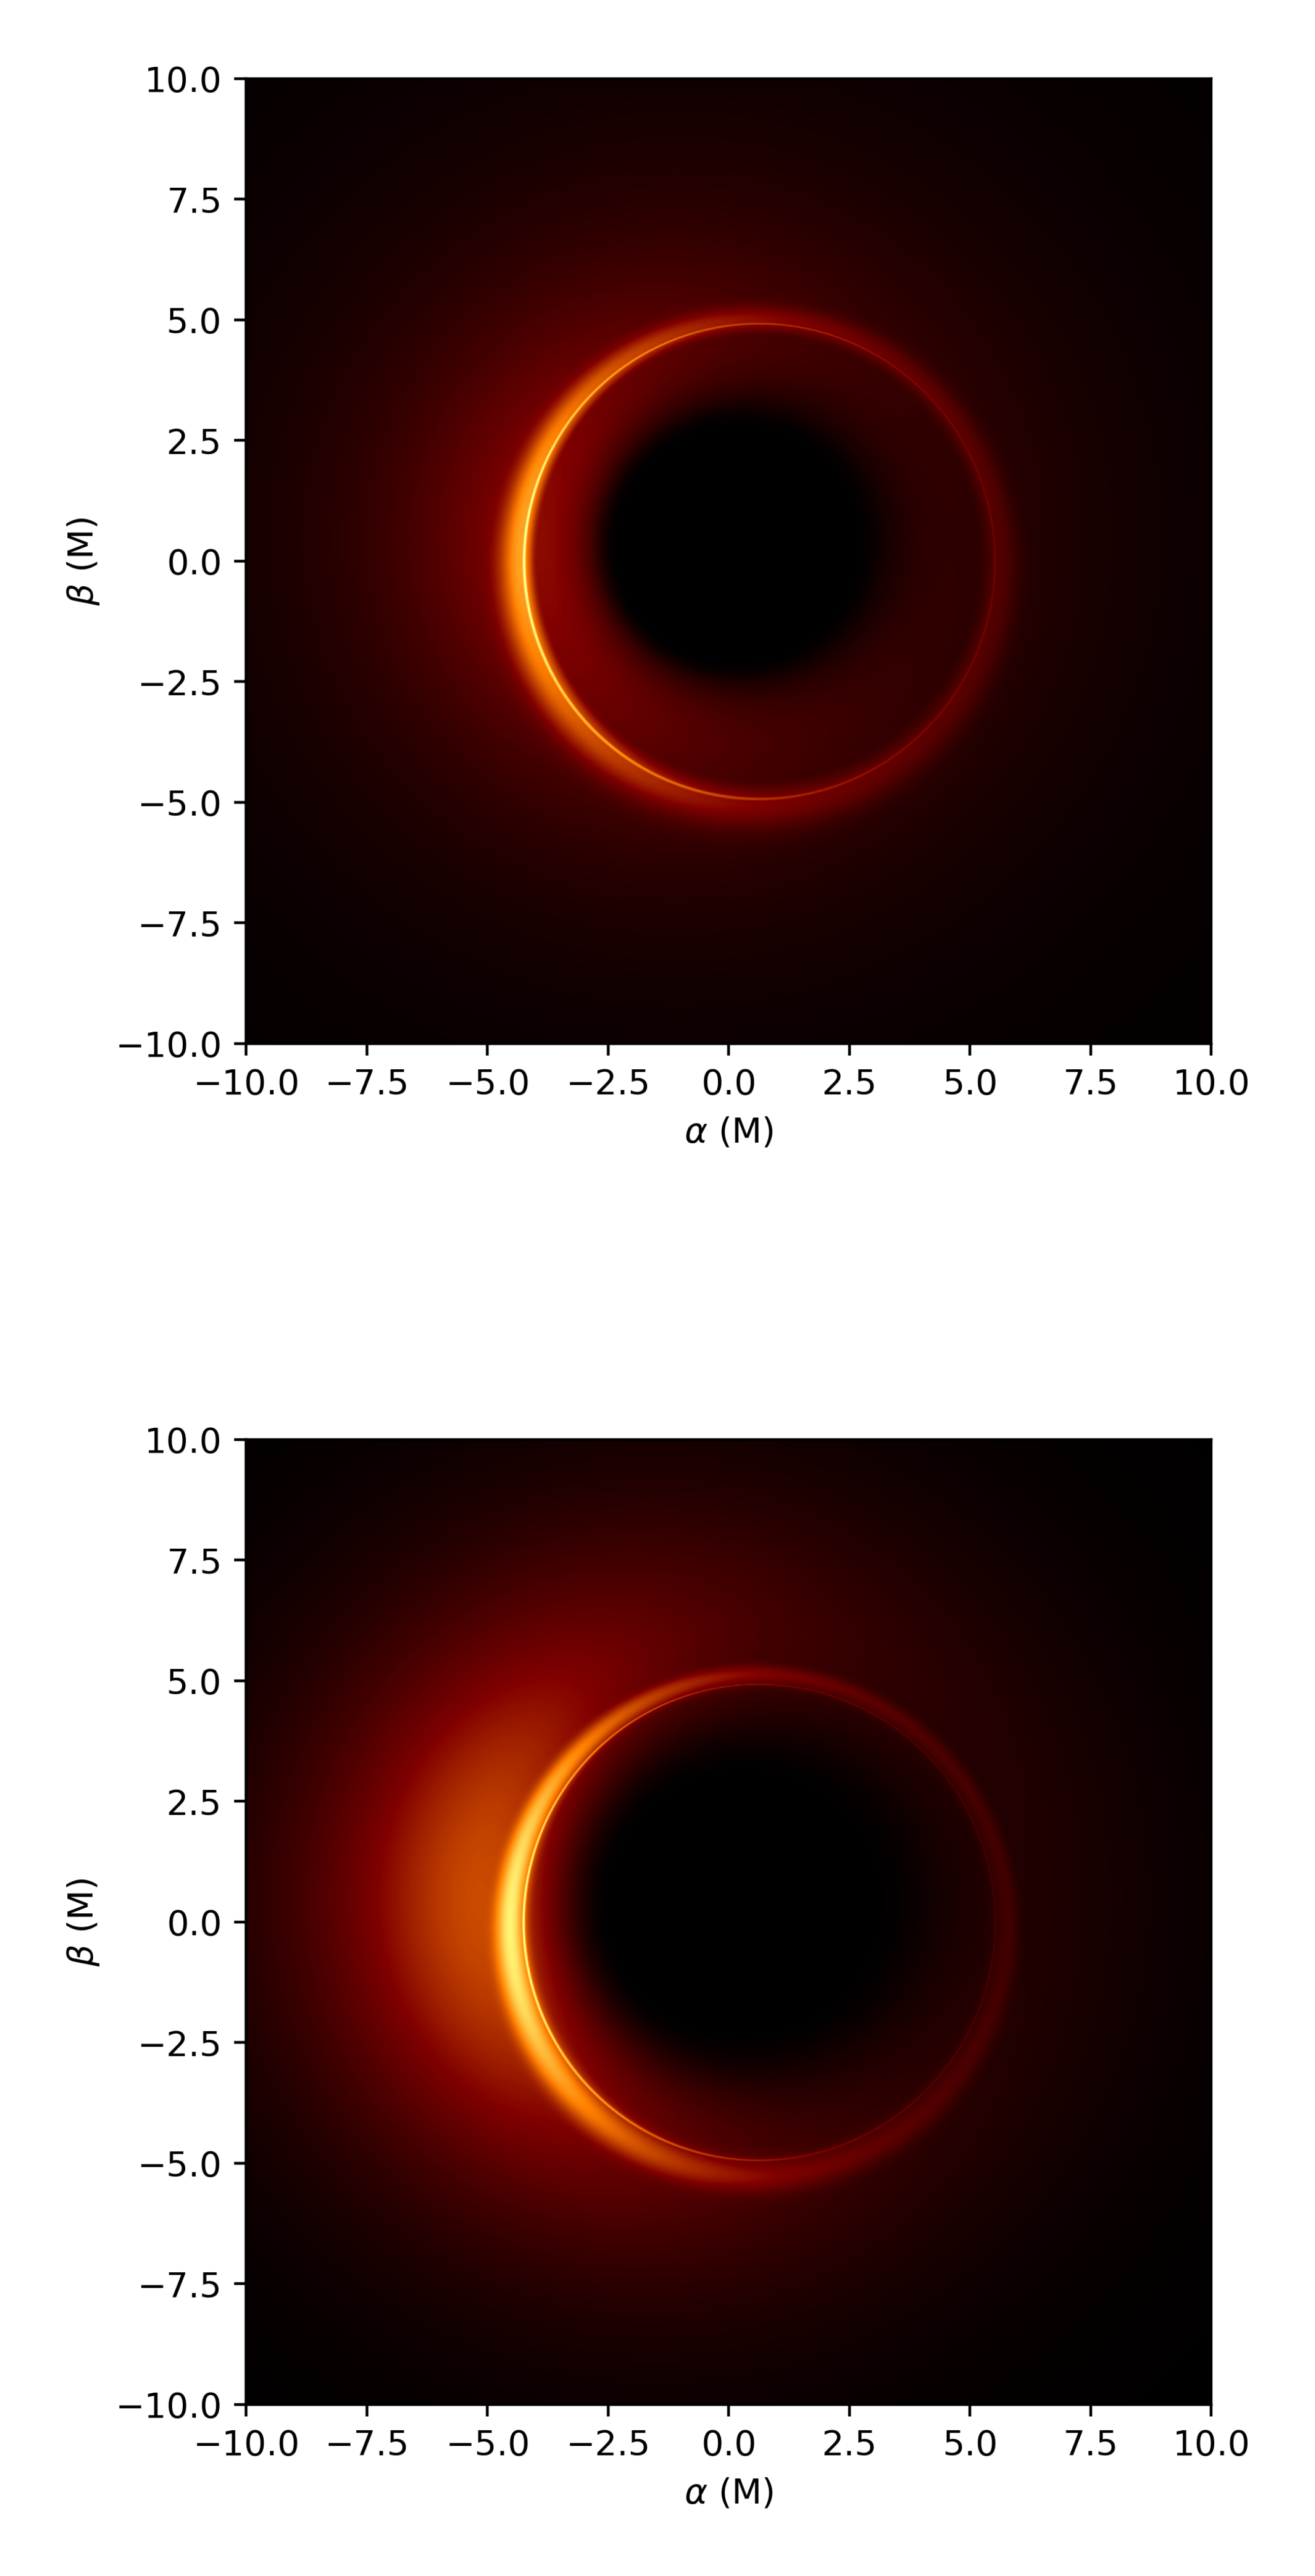

In [33]:
exampleBH = mpimg.imread('/home/tej/Desktop/Code_Stuff/Repositories/aart/Figures/ExampleBHimage.png')
idealBH = mpimg.imread('/home/tej/Desktop/Code_Stuff/Repositories/aart/Ideal_BHImage_a_0.94_i_17_nu_8.6e+10_mass_1.3e+43_scaleh_0.5_thetab_1.047e+00_beta_1.0e+00_rb0_6.0e+01_nth0_1.2e+04_te0_8.1e+09_pdens_-7.0e-01_ptemp_-8.4e-01.png')
fig =  plt.subplots(1,2,figsize=(5,8),dpi=800)
axs = [None, None]
axs[0] = plt.subplot(2,1,1)
axs[0].imshow(exampleBH)
axs[0].axis('off')

axs[1] = plt.subplot(2,1,2)
axs[1].imshow(idealBH)
axs[1].axis('off')
plt.savefig('./Paper_Figures/Figure_toyvsreal.png', bbox_inches='tight')

In [8]:
t = 1
xaxis = np.load('./Movie_Maker/xaxis_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_1.1e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-8.4e-01.mp4.npy')
r_outer = np.load('./Movie_Maker/r_outer_spin_0.94_inc_17.npy')
r_inner = np.load('./Movie_Maker/r_inner_spin_0.94_inc_17.npy')

r0_84 = np.load('./Movie_Maker/R0_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_1.1e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-8.4e-01.mp4.npy')
r1_84 = np.load('./Movie_Maker/R1_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_1.1e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-8.4e-01.mp4.npy')
r2_84 = np.load('./Movie_Maker/R2_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_1.1e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-8.4e-01.mp4.npy')

r0_1_6 = np.load('./Movie_Maker/R0_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_3.0e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-1.6e+00.mp4.npy')
r1_1_6 = np.load('./Movie_Maker/R1_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_3.0e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-1.6e+00.mp4.npy')
r2_1_6 = np.load('./Movie_Maker/R2_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_3.0e+05_te0_1.2e+11_pdens_-7.0e-01_ptemp_-1.6e+00.mp4.npy')

r0_3 = np.load('./Movie_Maker/R0_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_2.2e+04_te0_1.2e+11_pdens_-7.0e-01_ptemp_-3.0e-01.mp4.npy')
r1_3 = np.load('./Movie_Maker/R1_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_2.2e+04_te0_1.2e+11_pdens_-7.0e-01_ptemp_-3.0e-01.mp4.npy')
r2_3 = np.load('./Movie_Maker/R2_var_nu_start_3.000e+10_stop_7.000e+11_steps_2.500e+10_a_0.94_i_17_nu_6.6e+11_mass_1.3e+43_scaleh_0.5_thetab_8.727e-01_beta_1.0e+00_Rie_1.0e+01_Bchoi_0.0e+00_rb_2.0e+00_nth0_2.2e+04_te0_1.2e+11_pdens_-7.0e-01_ptemp_-3.0e-01.mp4.npy')

In [3]:
shadowlines = 3
ringlines = 2

fig = plt.subplots(1,1)
ax = [None]
ax[0] = plt.subplot(1,1,1)
ax[0].hlines(r_inner, xaxis[0], np.max(xaxis), colors='k', linewidth=shadowlines)
ax[0].hlines(r_outer, xaxis[0], np.max(xaxis), colors='tab:grey', linewidth=shadowlines)

ax[0].plot(xaxis, r0_84, color='tab:orange', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, r1_84, color='tab:orange', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, r2_84, color='tab:orange', linestyle=':', linewidth=ringlines)

ax[0].plot(xaxis, r0_1_6, color='tab:blue', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, r1_1_6, color='tab:blue', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, r2_1_6, color='tab:blue', linestyle=':', linewidth=ringlines)

ax[0].plot(xaxis, r0_3, color='tab:red', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, r1_3, color='tab:red', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, r2_3, color='tab:red', linestyle=':', linewidth=ringlines)

ax[0].set_xlabel(R'Frequency ($\nu$)')
ax[0].set_ylabel(R'Ring Radius ($R_g$)')
ax[0].set_xlim(xaxis[0], np.max(xaxis))
ax[0].set_ylim(2, 9)


lines = [
    Line2D([0],[0],marker='o', markerfacecolor='tab:red', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:orange', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:blue', color='w', markersize=12),
    Line2D([0,1],[0,1],linestyle='-', color='k'), 
    Line2D([0,1],[0,1],linestyle='--', color='k'), 
    Line2D([0,1],[0,1],linestyle=':', color='k')
    ]
labels = [
    R"$\alpha_t$= -.3",
    R"$\alpha_t$= -.84",
    R"$\alpha_t$= -1.6",
    R'$n = 0$',
    R'$n = 1$',
    R'$n = 2$'
          ]


ax[0].legend(lines,labels)
plt.savefig('./Paper_Figures/Figure_varylawradii.png', bbox_inches='tight')

NameError: name 'plt' is not defined

In [ ]:


#plt.savefig('./Paper_Figures/Figure_{}.png'.format(figureorder[4]), bbox_inches='tight')